In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from kerastuner.tuners import RandomSearch

In [ ]:
# import data

train = pd.read_csv('/min_train.csv', index_col=0)
val = pd.read_csv('/min_val.csv',index_col=0)
test = pd.read_csv('/min_test.csv', index_col=0)
test2 = pd.read_csv('/min_test2.csv', index_col=0)
test = pd.concat([test, test2], axis=0)

# Display the first few rows of the DataFrame
test.head()

,Bid1_Price,Bid1_Volume,Ask1_Price,Ask1_Volume,Bid2_Price,Bid2_Volume,Ask2_Price,Ask2_Volume,Mid_Price,Bid_Ask_Spread,...,Highest_Price,Trade_Volume,Price_Mean,RSI,MACD,MACD_signal,MACD_hist,KDJ_K,KDJ_D,KDJ_J
DateTime_Minute,,,,,,,,,,,,,,,,,,,,,
2025-06-02 07:30:00,111.00,2211,148.26,1371,108.47,1796,207.86,1403,129.63,37.26,...,119.00,97,112.61,52.83,-0.196021,-0.198977,0.002956,70.590658,68.966544,73.838884
2025-06-02 07:31:00,111.15,1845,159.25,1229,104.42,2542,238.43,1130,135.20,48.09,...,119.00,115,113.14,44.24,-0.495844,-0.258351,-0.237493,62.897872,66.943654,54.806310
2025-06-02 07:32:00,111.51,1581,161.75,1545,103.63,2152,245.34,1406,136.63,50.24,...,119.00,95,113.24,50.00,-0.677234,-0.342127,-0.335107,58.862843,64.250050,48.088428
2025-06-02 07:33:00,112.92,1399,188.79,1198,109.79,1420,235.82,1181,150.86,75.87,...,118.25,77,113.64,50.00,-0.412771,-0.356256,-0.056515,65.285270,64.595123,66.665564
2025-06-02 07:34:00,114.26,4271,154.78,2092,113.05,4829,215.01,1879,134.52,40.52,...,119.00,113,114.77,43.63,-0.420239,-0.369053,-0.051187,64.555043,64.581763,64.501602


In [ ]:
train_s = train['Bid_Ask_Spread']
val_s = val['Bid_Ask_Spread']
test_s = test['Bid_Ask_Spread']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_nr = scaler.fit_transform(train_s.values.reshape(-1, 1))
val_nr = scaler.transform(val_s.values.reshape(-1, 1))
test_nr = scaler.transform(test_s.values.reshape(-1, 1))

In [ ]:
# data windowing

def create_sequences(data, input_sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - input_sequence_length - forecast_horizon + 1):
        X.append(data[i:(i + input_sequence_length)])
        y.append(data[(i + input_sequence_length):(i + input_sequence_length + forecast_horizon)])
    return np.array(X), np.array(y)

input_sequence_length = 20
forecast_horizon = 5

X_train, y_train = create_sequences(train_nr, input_sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_nr, input_sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_nr, input_sequence_length, forecast_horizon)

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((42293, 20, 1),
 (42293, 5, 1),
 (10176, 20, 1),
 (10176, 5, 1),
 (11196, 20, 1),
 (11196, 5, 1))

In [ ]:
OUT_STEPS = 5
num_features = 1

In [ ]:
def build_model_s(hp):
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(20, 1)))  # Assuming input shape is (20, 1)

    # Tuning the number of LSTM layers
    for i in range(hp.Int('num_layers', 1, 2)):  # Let's say we want between 1 and 2 LSTM layers
        model.add(layers.LSTM(units=hp.Int('units_' + str(i), min_value=30, max_value=300, step=10),
                       return_sequences=True if i < hp.get('num_layers') - 1 else False))

    model.add(layers.Dense(
            OUT_STEPS * num_features,
            kernel_initializer=tf.initializers.zeros()
        )),
    model.add(layers.Reshape([OUT_STEPS, num_features]))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.0001])),
        loss='mse',
        metrics=['mean_squared_error']
    )
    return model

In [ ]:
tuner2 = RandomSearch(
    build_model_s,
    objective='val_loss',  # Targeting to minimize the validation loss
    max_trials=10,  # Number of trials to run (different model configurations)
    executions_per_trial=1,
    directory='my_dir_spread2',
    project_name='spread_tuning'
)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner2.search(
    X_train, y_train,  # assuming x_train and y_train are prepared
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),  # validation
    callbacks=[stop_early]
)

Trial 10 Complete [00h 13m 45s]
val_loss: 0.5053873658180237

Best val_loss So Far: 0.5041707158088684
Total elapsed time: 02h 12m 14s


In [ ]:
best_model = tuner2.get_best_models(num_models=1)[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 240)               232320    
                                                                 
 dense (Dense)               (None, 5)                 1205      
                                                                 
 reshape (Reshape)           (None, 5, 1)              0         
                                                                 
Total params: 233525 (912.21 KB)
Trainable params: 233525 (912.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def plot_results(X_train,X_val,X_test,y_train,y_val,y_test, model):
    # Creating indices for plotting
    train_x = np.arange(len(y_train))
    val_x = np.arange(len(y_val))
    test_x = np.arange(len(y_test))

    # Making predictions
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)

    # Creating a figure and subplots
    plt.figure(figsize=(20, 15))  # Adjusted for better vertical display

    # Subplot for the training set
    plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
    plt.plot(train_x, y_train[:, 0], label='Actual')
    plt.plot(train_x, pred_train[:, 0], label='Predicted')
    plt.title('Training Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the validation set
    plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
    plt.plot(val_x, y_val[:, 0], label='Actual')
    plt.plot(val_x, pred_val[:, 0], label='Predicted')
    plt.title('Validation Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the test set
    plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
    plt.plot(test_x, y_test[:, 0], label='Actual')
    plt.plot(test_x, pred_test[:, 0], label='Predicted')
    plt.title('Test Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

350/350 [==============================] - 6s 16ms/step


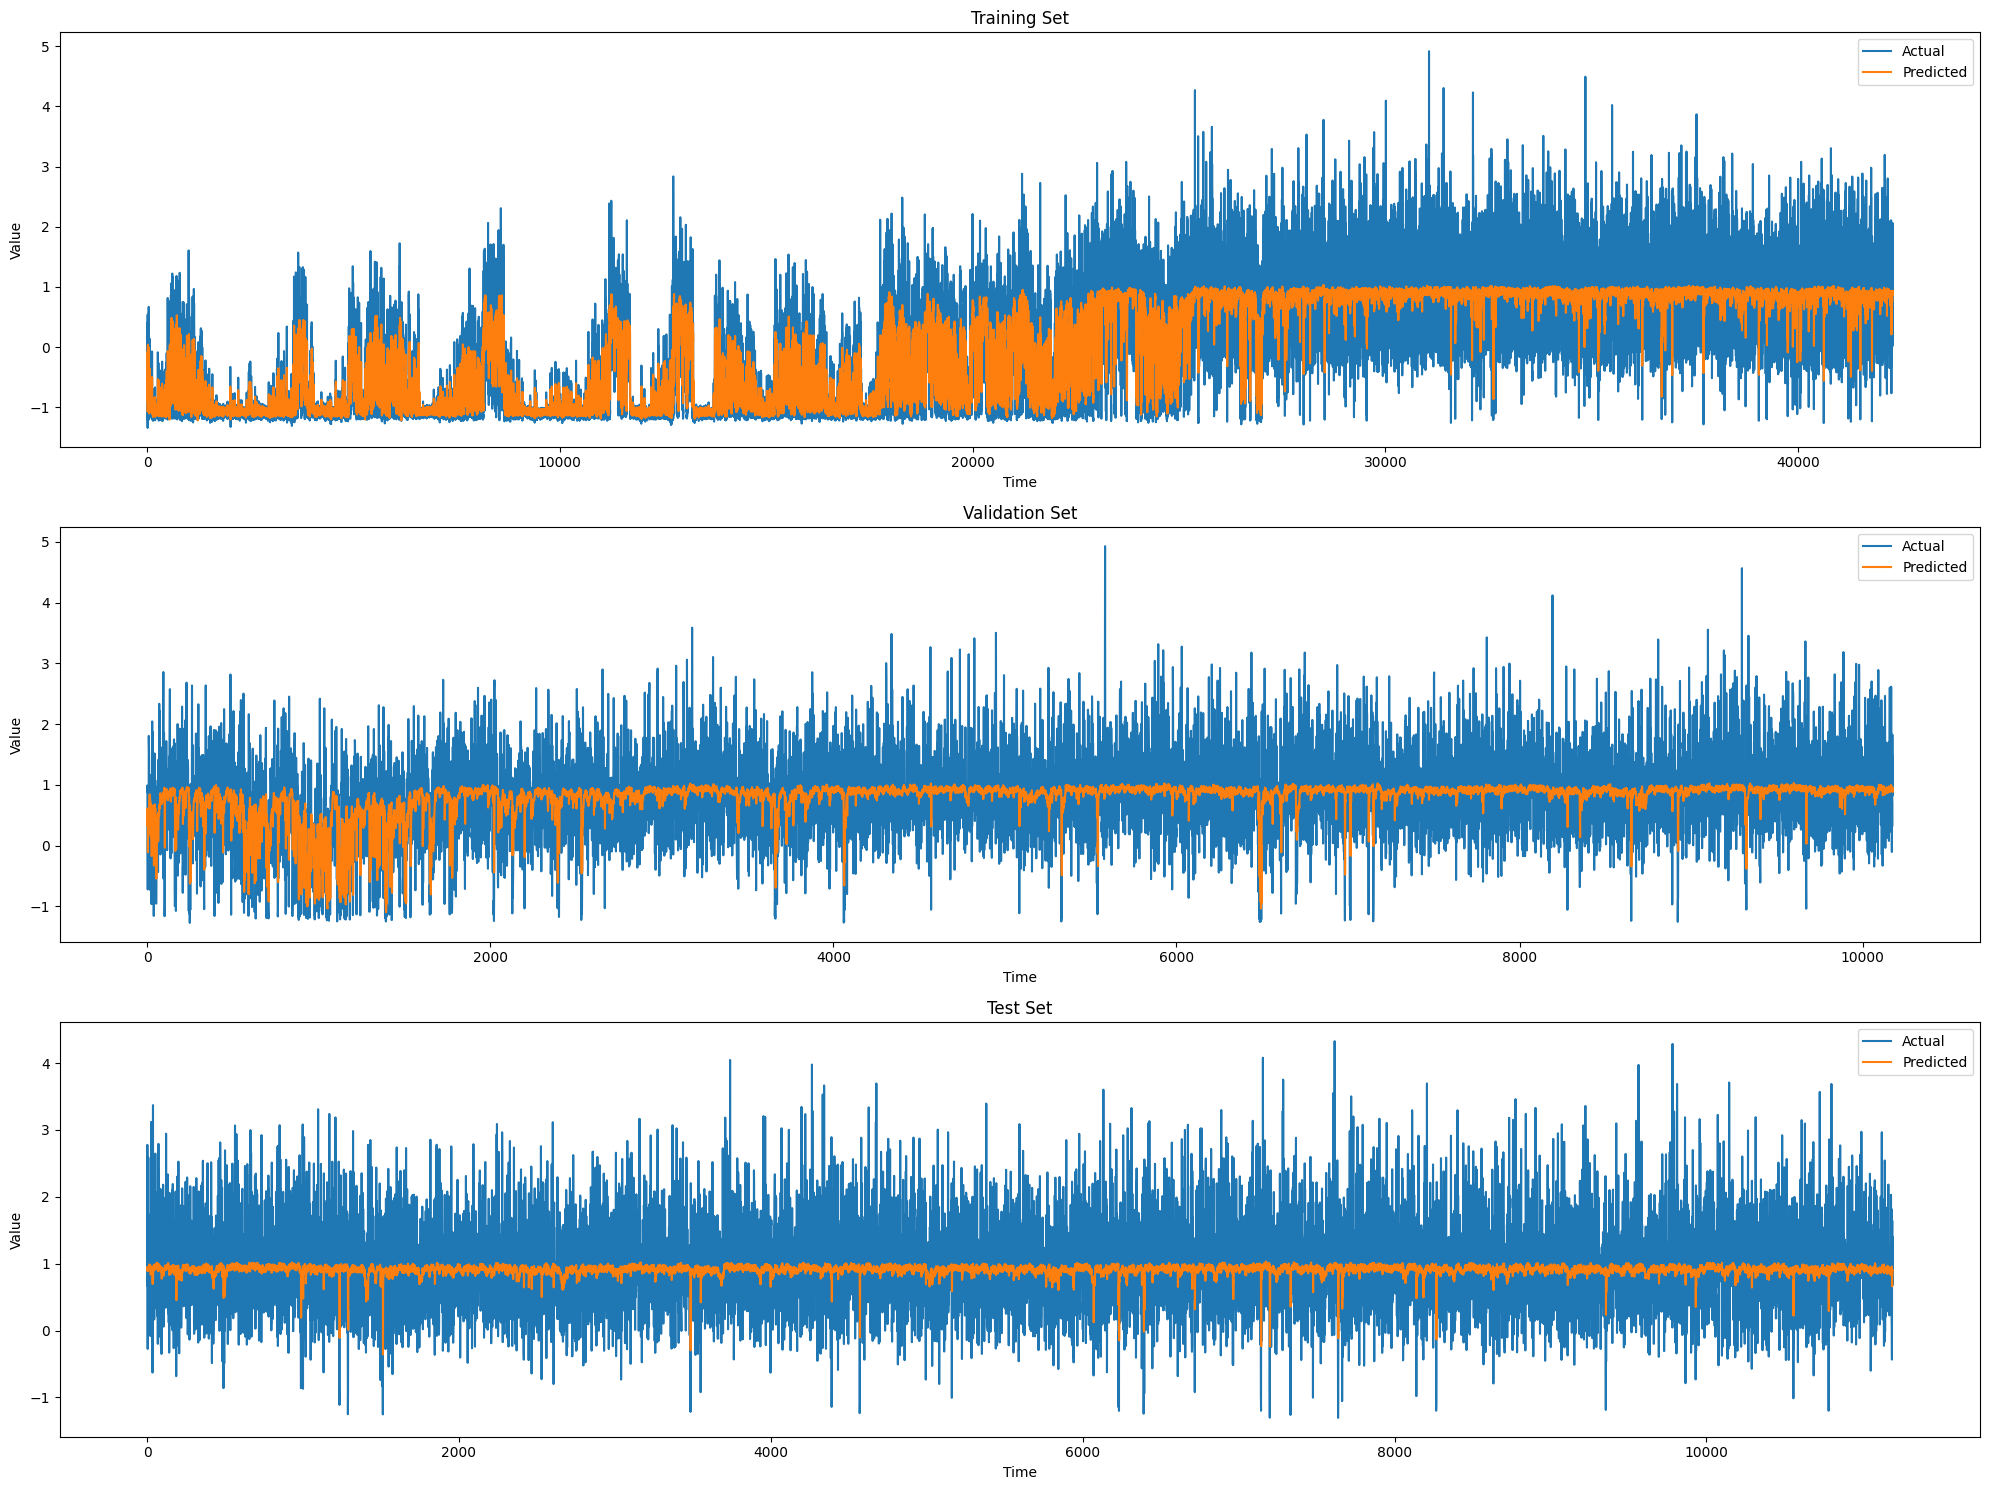

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, best_model)

In [ ]:
# Save the model

best_model.save('/Users/chenyian/DS_mini_project/LSTM_forecasting/spread_LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 240)               232320    
                                                                 
 dense (Dense)               (None, 5)                 1205      
                                                                 
 reshape (Reshape)           (None, 5, 1)              0         
                                                                 
Total params: 233525 (912.21 KB)
Trainable params: 233525 (912.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
trials = tuner2.oracle.get_best_trials()

# Iterate through all trials and print their hyperparameters and score
for trial in trials:
    print("Trial ID:", trial.trial_id)
    print("Hyperparameters:", trial.hyperparameters.values)
    print("Score:", trial.score)

Trial ID: 08
Hyperparameters: {'num_layers': 1, 'units_0': 240, 'learning_rate': 0.001, 'units_1': 180}
Score: 0.5041707158088684
